In [4]:
from google.cloud import storage


client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)

cats-vs-dogs/
cats-vs-dogs/processed/catsvsdogs.npy
cats-vs-dogs/raw-data/
cats-vs-dogs/raw-data/catsanddogs.zip
celeba/
celeba/processed/
celeba/processed/celebalign_processed.npy
celeba/zips/
celeba/zips/img_align_celeba.zip
celeba/zips/img_celeba.7z-20201107T135448Z-002.zip
celeba/zips/img_celeba.7z.001
faces/
faces/processed-images/
faces/videos/
tdt4173-datasets/celeba/processed/celebalign_processed.npy


In [5]:
zipfilename = "/home/jupyter/data/img_align_celeba.zip"

In [ ]:
blob_name = "celeba/zips/img_align_celeba.zip"
blob = bucket.get_blob(blob_name)

blob.download_to_filename(zipfilename)

In [ ]:
import zipfile
with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall("/home/jupyter/data/celeb-align-1")

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from glob import glob

(224, 224)


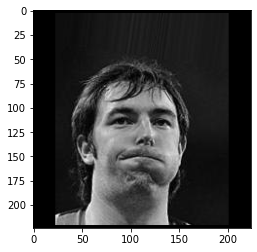

In [7]:
os.listdir("/home/jupyter/data/celeb-align-1/img_align_celeba")
img = cv2.imread("/home/jupyter/data/celeb-align-1/img_align_celeba/003656.jpg", cv2.IMREAD_GRAYSCALE)
h, w = img.shape
img = cv2.copyMakeBorder(
    img,
    top=int((224-h) / 2),
    right=int((224-w) / 2),
    bottom=int((224-h) / 2),
    left=int((224-w) / 2),
    borderType=cv2.BORDER_CONSTANT,
)
print(img.shape)
plt.imshow(img, cmap="gray");

In [9]:
class CelebAlign:
    IMG_SIZE = 224
    BASE_PATH = "/home/jupyter/data/celeb-align-1"
    training_data = []

    counts = Counter()

    def __init__(self):
        self.labels = {}
        unique = set()
        with open(os.path.join(self.BASE_PATH, "identity_CelebA.txt"), "r") as f:
            for line in f.readlines():
                name, label = line.split()
                self.labels[name] = int(label)
                unique.add(label)
        
        self.num_labels = len(unique)
        print("Number of labels:", self.num_labels)
    
    def make_training_data(self):
        for i, path in enumerate(tqdm(glob(os.path.join(self.BASE_PATH, "img_align_celeba", "*.jpg")))):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            h, w = img.shape
            img = cv2.copyMakeBorder(
                img,
                top=int((self.IMG_SIZE-h) / 2),
                right=int((self.IMG_SIZE-w) / 2),
                bottom=int((self.IMG_SIZE-h) / 2),
                left=int((self.IMG_SIZE-w) / 2),
                borderType=cv2.BORDER_CONSTANT,
            )
            label = self.labels[path.split(os.path.sep)[-1]]
            self.training_data.append([img, label])

            self.counts[label] += 1
                

        np.random.shuffle(self.training_data)
        np.save(os.path.join(self.BASE_PATH, "processed/celebalign_processed.npy"), self.training_data)

celeb = CelebAlign()
celeb.make_training_data()

Number of labels: 10177


  1%|▏         | 2859/202599 [01:02<1:12:16, 46.06it/s]


KeyboardInterrupt: 

In [ ]:
blob_name = "celeba/processed/celebalign_processed.npy"
blob = bucket.blob(blob_name)

source_file_name = os.path.join(CelebAlign.BASE_PATH, "processed/celebalign_processed.npy")
blob.upload_from_filename(source_file_name)

## Convert from numpy-data to tensor

In [3]:
import numpy as np
import torch

In [1]:
data_file = "/home/jupyter/data/celeb-align-1/processed/celebalign_processed1.npy"
data = np.load(data_file, allow_pickle=True)

In [2]:
IMAGE_SIZE = 224
x = torch.Tensor(list(data[0])).view(-1, IMAGE_SIZE, IMAGE_SIZE)
x /= 255.0

In [5]:
unique = set(data[1])
class_mapping = {elem: idx for idx, elem in enumerate(unique)}

In [6]:
y = torch.Tensor([class_mapping[elem] for elem in data[1]]).to(torch.int64)

In [7]:
torch.save(
    {
        "x": x,
        "y": y,
        "num_classes": len(unique),
    },
    "/home/jupyter/data/celeb-align-1/tensors/celebalign_processed1.torch",
)